# DSE Dissertation

## Topic Analysis

In [1]:
# Mount Google Drive to access required files

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Load Packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sn
from wordcloud import WordCloud
import re
import spacy
import codecs
import csv
import sys

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
!pip install Unidecode
import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 6.0 MB/s eta 0:00:00


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

#### Load Dataset

In [6]:
"""

Loading dataset

"""

class UtteranceExample:
    def __init__(self, text, label, do_lower_case):
        self.original_text = text
        self.text = text
        self.label = label

        if do_lower_case:
            self.text = self.text.lower()

    def to_dict(self):
      return {
          'utterance': self.original_text,
          'intent': self.label,
      }
        
def load_utterance_examples(file_path, do_lower_case=True):
    examples = []

    with open('{}/seq.in'.format(file_path), 'r', encoding="utf-8") as f_text, open('{}/label'.format(file_path), 'r', encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            e = UtteranceExample(text.strip(), label.strip(), do_lower_case)
            examples.append(e)

    return examples



In [7]:
data = load_utterance_examples("/content/drive/MyDrive/Dissertation/Topic_Analysis/dataset/train", False)

utterances= pd.DataFrame.from_records([d.to_dict() for d in data])

print(utterances.head())

                                           utterance        intent
0                     i am still waiting on my card?  card_arrival
1  what can i do if my card still hasn't arrived ...  card_arrival
2  i have been waiting over a week. is the card s...  card_arrival
3  can i track my card while it is in the process...  card_arrival
4  how do i know if i will get my card, or if it ...  card_arrival


### Exploratory Data Analysis

In [ ]:
utterances.shape

(8622, 2)

In [ ]:
utterances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8622 entries, 0 to 8621
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  8622 non-null   object
 1   intent     8622 non-null   object
dtypes: object(2)
memory usage: 134.8+ KB


In [ ]:
utterances.describe()

,utterance,intent
count,8622,8622
unique,8618,77
top,where can i withdraw money from?,card_payment_fee_charged
freq,2,167


In [8]:
utterances.dropna(axis=0,inplace=True)#dropping na
utterances.shape

(8622, 2)

In [9]:
utterances.drop_duplicates(subset=['utterance'],inplace=True)#dropping duplicates
utterances.shape

(8618, 2)

In [ ]:
#Look for missing intents
utterances['intent'].isnull().sum()

0

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

type_counts_train = utterances['intent'].value_counts(sort=True, ascending=True)

#Another way of printing the values.
#print(pd.DataFrame({'count' : utterances.groupby( [ "intent"] ).size()}).reset_index().sort_values('count'))

print(type_counts_train)

"""

It shows that the utterances per intent are imbalanced.

TOTAL OF 77 INTENT CLASSES

"""
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)

contactless_not_working                              30
virtual_card_not_working                             32
card_swallowed                                       45
card_acceptance                                      47
lost_or_stolen_card                                  66
atm_support                                          68
compromised_card                                     72
get_disposable_virtual_card                          78
top_up_limits                                        79
receiving_money                                      80
getting_virtual_card                                 82
unable_to_verify_identity                            86
passcode_forgotten                                   87
verify_my_identity                                   87
topping_up_by_card                                   87
get_physical_card                                    88
terminate_account                                    91
age_limit                                       

### Data Pre-processing.
- Profanity Removal.
- Spelling correction.
- Remove Punctuation.
- Remove stop words.
- Tokenization.
- Lemmatization.


##### Profanity removal.

In [ ]:
!pip install better_profanity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 KB 2.7 MB/s eta 0:00:00


In [ ]:
from better_profanity import profanity

In [ ]:
def censored_correction(text):
  if(profanity.contains_profanity(text)):
    return profanity.censor(text)
  else:
    return text

In [ ]:
corrected_utterances = []

for t in utterances['utterance']:
    corrected_utterances.append(censored_correction(t))

corrected_utterances[:5]
utterances['utterance'] = corrected_utterances
utterances.head()

NameError: ignored

##### Spelling correction.

In [11]:
! pip install -U symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 KB 5.9 MB/s eta 0:00:00


In [12]:
#Spelling correction using Symspell.

from symspellpy import SymSpell, Verbosity
import pkg_resources
from itertools import islice

##### Creating a dictionary out of dataset

In [13]:
# Initialise Symspell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7, count_threshold=4)

In [14]:
banking_terms = "/content/drive/MyDrive/Dissertation/Topic_Analysis/banking_dict.txt"
banking_dict = sym_spell.create_dictionary(banking_terms, encoding='utf-8')
banking_dict

True

In [15]:
corpus_path = "/content/drive/MyDrive/Dissertation/Topic_Analysis/dataset/train/seq.in"
corpus_dict = sym_spell.create_dictionary(corpus_path, encoding='utf-8')
corpus_dict

True

In [16]:
loc_corpus_path = "/content/drive/MyDrive/Dissertation/Topic_Analysis/us_cities_states_counties.csv"
loc_corpus_text_unigram = "/content/drive/MyDrive/Dissertation/Topic_Analysis/us_cities_states_counties_unigram.txt"
loc_corpus_text_bigram = "/content/drive/MyDrive/Dissertation/Topic_Analysis/us_cities_states_counties_bigram.txt"

In [17]:
def removeDuplicates(fileName):
  f = open(fileName, 'r')
  lines = set(f.readlines())
  f.close()
  a = open(fileName, 'w')
  a.writelines(lines)
  a.close()


In [18]:
def getUSCitiesStateCountyLists():
  file_unigram = open(loc_corpus_text_unigram, 'w')
  file_bigram = open(loc_corpus_text_bigram, 'w')
  infile = open(loc_corpus_path, mode='r', newline='')
  reader = csv.DictReader(infile)
  header = next(reader)  # store the headers and advance reader pointer
  for rows in reader:
    row_val = rows['City|State short|State full|County|City alias']
    divided_row = row_val.split('|')
    #print(divided_row)
    if len(divided_row) >= 1:
      city_name = divided_row[0]
      if len(city_name.split()) > 1:
        file_bigram.write(city_name.title()+'\n')
      else:
        file_unigram.write(city_name.title()+'\n')

      if len(divided_row) >= 3:
        state_full = divided_row[2]
        if len(state_full.split()) > 1:
          file_bigram.write(state_full.title()+'\n')
        else:
          file_unigram.write(state_full.title()+'\n')

        if len(divided_row) >= 4:
          county = divided_row[3]
          if len(county.split()) > 1:
            file_bigram.write(county.title()+'\n')
          else:
            file_unigram.write(county.title()+'\n')
  file_unigram.close()
  file_bigram.close()
  infile.close()
  removeDuplicates(loc_corpus_text_unigram)
  removeDuplicates(loc_corpus_text_bigram)

In [19]:
getUSCitiesStateCountyLists()

In [20]:
#Load USA location Gazetteer as dictionary to sym_spell
loc_corpus_dict = sym_spell.create_dictionary(loc_corpus_text_unigram, encoding='utf-8')
print(loc_corpus_dict)
loc_corpus_dict = sym_spell.create_dictionary(loc_corpus_text_bigram, encoding='utf-8')
print(loc_corpus_dict)

True
True


In [21]:
# Load the dictionaries provided by library

#dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
dictionary_path = "/content/drive/MyDrive/Dissertation/Topic_Analysis/en-80k.txt"

# term_index is the column of the term and count_index is the
# column of the term frequency
#sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

suggestions = sym_spell.lookup("New Yrok", Verbosity.CLOSEST, max_edit_distance=2, transfer_casing=True)
for suggestion in suggestions:
    print(suggestion)

# Print out first 5 elements to demonstrate that dictionary is
# successfully loaded
#print(list(islice(sym_spell.bigrams.items(), 5)))
#print(list(islice(sym_spell.words.items(), 5)))

# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
input_term = (
    "I want to do auto pya with Zelle on my crad in Nwe Yrok"
)
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2, ignore_non_words=True, transfer_casing=True)
# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

def spell_correction(input_term, max_edit_distance=2):
  suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
  #for suggestion in suggestions:
  #  print(suggestion.term)
  return suggestions[0].term

I want to do auto pay with Zelle on my card in NEw YOrk, 6, 0


In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [23]:
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

##### Preprocessing using regular expression.

In [ ]:
stop_words = set(stopwords.words('english')) 

# Text cleanup using regex
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)   # removing special characters
    newString = re.sub('"','', newString)              # removing '"' 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    # replacing slangs
    newString = re.sub(r"'s\b","",newString)    # replacing 's with "" '
    newString = re.sub("[^a-z]", " ", newString)    #only keeping letters
    newString = re.sub('[m]{2,}', 'mm', newString)    # "mmmmmm" -> "mm"
        
    tokens = [w for w in newString.split() if not w in stop_words]     # removing the stopwords

    long_words=[]
    for i in tokens:
        if len(i)>1:                               #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

    
#Lemmatization

def lemma(tokenized_text):
  wordnetLemmatizer = nltk.WordNetLemmatizer()
  text = [wordnetLemmatizer.lemmatize(word) for word in tokenized_text]
  return (" ".join(text)).strip()

In [ ]:
#call the function text_cleaner if you want to use text pre-processing using text_cleaner method.
cleaned_text = []
for t in utterances['utterance']:
    cleaned_text.append(text_cleaner(t)) 

utterances['cleaned_utterance'] = cleaned_text
utterances['lemmatized_utterance'] = utterances['cleaned_utterance'].apply(lambda x: lemma(x.split(" ")))

#Drop empty rows
utterances.replace('', np.nan, inplace=True)
utterances.dropna(axis=0,inplace=True)

utterances.head()

##### Pre-processing using Spacy

In [24]:
# Text cleanup and lemmatization combined using Spacy

nlp = spacy.load("en_core_web_sm")

def spacy_text_preprocessor(text):
  try:
        decoded_text = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
  except:
        decoded_text = unidecode.unidecode(text)

  apostrophe_handled = re.sub("’", "'", decoded_text)
  apostrophe_s_handled = re.sub(r"'s\b","",apostrophe_handled)
  expanded_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
  parsed = nlp(expanded_text)
  final_tokens = []

  for t in parsed:
      if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
          pass
      else:
          if t.lemma_ == '-PRON-':
              final_tokens.append(str(t))
          else:
              specialchar_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
              if len(specialchar_removed) > 1:
                  final_tokens.append(specialchar_removed)

  joined_str = ' '.join(final_tokens)
  text_corrected = re.sub(r'(.)\1+', r'\1\1', joined_str)
  return text_corrected

In [25]:

#utterances['clean_text_spacy'] = [spacy_text_preprocessor(t) for t in utterances['utterance']]
utterances['lemmatized_utterance'] = [spacy_text_preprocessor(t) for t in utterances['utterance']]
utterances.head()

,utterance,intent,lemmatized_utterance
0,i am still waiting on my card?,card_arrival,be still wait on my card
1,what can i do if my card still hasn't arrived ...,card_arrival,what can do if my card still have not arrive a...
2,i have been waiting over a week. is the card s...,card_arrival,have be wait over week be the card still come
3,can i track my card while it is in the process...,card_arrival,can track my card while it be in the process o...
4,"how do i know if i will get my card, or if it ...",card_arrival,how do know if will get my card or if it be lose


In [26]:
# call the function spell_correction

corrected_utterances = []

for t in utterances['lemmatized_utterance']:
    corrected_utterances.append(spell_correction(t)) 

utterances['lemmatized_utterance'] = corrected_utterances
utterances.head()

,utterance,intent,lemmatized_utterance
0,i am still waiting on my card?,card_arrival,be still wait on my card
1,what can i do if my card still hasn't arrived ...,card_arrival,what can do if my card still have not arrive a...
2,i have been waiting over a week. is the card s...,card_arrival,have be wait over week be the card still come
3,can i track my card while it is in the process...,card_arrival,can track my card while it be in the process o...
4,"how do i know if i will get my card, or if it ...",card_arrival,how do know if will get my card or if it be lost


##### Using Gazetteers for Named Entity Recognition

In [ ]:
# Using either Spacy NER or StanfordNERTagger to get the Named Entities from the dataset.



### Using WordCloud, display the frequent words in specific intent category

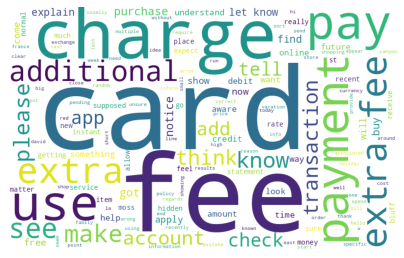

In [27]:
## word cloud for highest count for intent = 'card_payment_fee_charged'

intent_text = ""
for t in utterances[utterances['intent'] == 'card_payment_fee_charged']['lemmatized_utterance']:
    intent_text += t +" "
wordCloud = WordCloud(width=800, height=500, background_color='white').generate(intent_text)
plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.axis("Off")
plt.show()

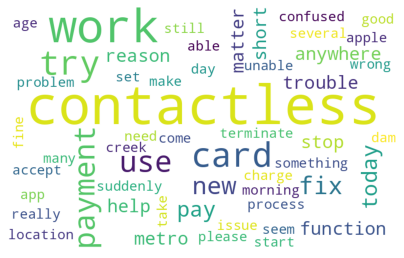

In [28]:
## word cloud for lowest count intent = 'contactless_not_working	'

intent_text = ""
for t in utterances[utterances['intent'] == 'contactless_not_working']['lemmatized_utterance']:
    intent_text += t +" "
wordCloud = WordCloud(width=800, height=500, background_color='white').generate(intent_text)
plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.axis("Off")
plt.show()

### Label Encode the class label i.e. 'intent' column

In [29]:
from sklearn import preprocessing

labelEncoding = preprocessing.LabelEncoder()
utterances['intent_labelEncoded'] = labelEncoding.fit_transform(utterances['intent']) 
utterances.head()

,utterance,intent,lemmatized_utterance,intent_labelEncoded
0,i am still waiting on my card?,card_arrival,be still wait on my card,12
1,what can i do if my card still hasn't arrived ...,card_arrival,what can do if my card still have not arrive a...,12
2,i have been waiting over a week. is the card s...,card_arrival,have be wait over week be the card still come,12
3,can i track my card while it is in the process...,card_arrival,can track my card while it be in the process o...,12
4,"how do i know if i will get my card, or if it ...",card_arrival,how do know if will get my card or if it be lost,12


##### Preparing Test Data

In [ ]:
data = load_utterance_examples("/content/drive/MyDrive/Dissertation/Topic_Analysis/dataset/BANKING77/test", False)
test_utterances= pd.DataFrame.from_records([d.to_dict() for d in data])
print(test_utterances.head())

                                           utterance        intent
0                           how do i loacte my card?  card_arrival
1  i still have not received my new card, i order...  card_arrival
2  i ordered a card but it has not arrived. hlep ...  card_arrival
3   is there a wya to know when my card will arrive?  card_arrival
4                       my card has not arrived yet.  card_arrival


In [ ]:
# Preprocess test data



### Model Building and testing using MultiNomialNB using Count Vectorizer and tf-idf Vectorizer


##### Method to display confusion matrix for the model evaluation.

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  y_labels = np.unique(y_test)
  cm = confusion_matrix(y_test, y_pred, labels=y_labels)
  cm_df = pd.DataFrame(cm, index=y_labels, columns=y_labels)
  cm_df.index.name= "Actual"
  cm_df.columns.name = "Predicted"
  fig, ax = plt.subplots(1, 1, figsize=(50, 50))
  sn.heatmap(cm_df, annot=True, ax=ax, linewidth=0.5, cmap="crest")
  plt.title("Confusion Matrix")
  plt.show()


##### Method to print total TP, FP, TN, FN

In [ ]:
def print_total_values(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
  TP = (np.diag(cm)).astype(float)
  FP = (cm.sum(axis=0) - np.diag(cm)).astype(float)
  FN = cm.sum(axis=1) - np.diag(cm).astype(float)
  TN = cm.sum() - (FP + FN + TP).astype(float)

  print(f"Total True Positives : ",np.sum(TP))
  print(f"Total False Positives : ",np.sum(FP))
  print(f"Total True Negatives : ",np.sum(TN))
  print(f"Total False Negatives : ",np.sum(FN))


##### Print TP, FP, TN, FN as part of classification report

In [ ]:
def multiclass_classification_report(y_test, y_pred):
    conf_labels = None
    
    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    counter = np.unique(y_test)
        
    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
    
    return pd.DataFrame(report)


Model building using MultiNomialNB (Naive Bayes) Model and uni-gram CountVectorizer for Classification

In [ ]:
"""
Now convert each message into a vector that machine learning models can understand.

"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
y = utterances['intent']
X = utterances['lemmatized_utterance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

# Initialize uni-gram CountVectorizer
vectorizer = CountVectorizer()
X_train_v = vectorizer.fit_transform(X_train.values)

# Display count of data samples for each intent in y_test
display(y_test.value_counts(sort=True, ascending=True))

# Initalize MNB classifier and fit with features
count_vectorizer_unigram_MNB_model = MultinomialNB().fit(X_train_v, y_train)

#print(f"X_test utterances", X_test)
X_test_v = vectorizer.transform(X_test.values)

# get the predictions for X_test using pipeline object
y_pred = count_vectorizer_unigram_MNB_model.predict(X_test_v)

# Print the predicted intent for each utterance in X_test dataset
print(f" Utterance : Prediction")
res = "\n".join("{}:  {}".format(x, y) for x, y in zip(X_test, y_pred.tolist()))
print(res)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

# Plot heatmap of confusion matrix
plot_confusion_matrix(y_test, y_pred)

#Print total TP, FP, TN, FN
print_total_values(y_test, y_pred)

# Add TP, TN, FP, FN as part of classification report
display(multiclass_classification_report(y_test, y_pred))
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 5)


Model building using MultiNomialNB (Naive Bayes) Model and bi-gram CountVectorizer for Classification

In [ ]:
# bi-gram CountVectorizer using pipeline approach

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Creating a pipeline object
count_vector_MNB_pipeline = Pipeline([
    ('vectorizer_bigrams', CountVectorizer(ngram_range = (2, 2))), 
     ('Multi NB', MultinomialNB())         
])
 
# fit with features
count_vector_MNB_pipeline.fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = count_vector_MNB_pipeline.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

Model building using MultiNomialNB (Naive Bayes) Model and uni-gram and bi-gram CountVectorizer for Classification

In [ ]:
# uni-gram, bi-gram CountVectorizer
unibigram_vectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(unibigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_unibigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_unibigram_MNB_model.predict(X_test)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

Model building using MultiNomialNB (Naive Bayes) Model and uni-gram, bi-gram, tri-gram CountVectorizer for Classification

In [ ]:
# uni-gram, bi-gram, tri-gram CountVectorizer

trigram_vectorizer = CountVectorizer(ngram_range=(1,3)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(trigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_trigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_trigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted"))
print (classification_report(y_test, y_pred))

Model building using MultiNomialNB (Naive Bayes) Model and trigram CountVectorizer for Classification

In [ ]:
#tri-gram CountVectorizer

trigram_vectorizer = CountVectorizer(ngram_range=(3,3)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(trigram_vectorizer.todense())
#print("Shape of X: ", X.shape)
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
ctvectorizer_trigram_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = ctvectorizer_trigram_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

###Model building using MultiNomialNB (Naive Bayes) Model and tf-idf (term frequency - inverse document frequency) vectorizer for Classification


In [ ]:
# Using TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

# Initalize MNB classifier and fit with features
tfidfvectorizer_MNB_model = MultinomialNB().fit(X_train, y_train)

# get the predictions for X_test using pipeline object
y_pred = tfidfvectorizer_MNB_model.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None))
print (classification_report(y_test, y_pred))

In [ ]:
# tf-idf vectorizer and MNB model using Pipeline approach

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

# Creating a pipeline object
tfidf_vector_MNB_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])
 
 #fit with features
tfidf_vector_MNB_pipeline.fit(X_train, y_train)

#get the predictions for X_test using pipeline object
y_pred = tfidf_vector_MNB_pipeline.predict(X_test)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted"))
print (classification_report(y_test, y_pred))

### Using KNN (K Nearest Neighbour) Model and CountVectorizer

##### Using ngram_range as unigram and bigram and metric as Euclidean distance.

In [ ]:
# CountVectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
count_vector_KNN1_pipeline = Pipeline([
    ('vectorizer_count', CountVectorizer()),        #using the ngram_range parameter 
     ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'))         
])
 
 #fit with features
count_vector_KNN1_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = count_vector_KNN1_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

##### Using ngram_range as unigram, bigram and trigram and metric as cosine distance.

In [ ]:
# CountVectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
count_vector_KNN2_pipeline = Pipeline([
    ('vectorizer_count', CountVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))         
])
 
 #fit with features
count_vector_KNN2_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = count_vector_KNN2_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

### Using KNN (K Nearest Neighbour) Model and TF-IDF Vectorizer

#####Using Euclidean distance metric.

In [ ]:
# TF-IDF Vectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
tfidf_vector_KNN1_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean'))         
])
 
 #fit with features
tfidf_vector_KNN1_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = tfidf_vector_KNN1_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

#####Using Cosine distance metric.

In [ ]:
# TF-IDF Vectorizer and KNN model using Pipeline approach 

X = utterances['lemmatized_utterance']
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Creating a pipeline object
tfidf_vector_KNN2_pipeline = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),       
     ('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance', metric='cosine'))         
])
 
 #fit with features
tfidf_vector_KNN2_pipeline.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = tfidf_vector_KNN2_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

print (classification_report(y_test, y_pred))

### Using SVM (Support Vector Machine) Model and TF-IDF Vectorizer

##### Using TF-IDF Vectorizer

In [ ]:
# TF-IDF Vectorizer and SVM model 

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

SVM_classifier_model1 = SVC(kernel='linear', gamma='auto')

#fit with features
SVM_classifier_model1.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = SVM_classifier_model1.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average=None)) #Weighted F1 score since data is imbalanced.

print (classification_report(y_test, y_pred))


##### Using Count Vectorizer

In [ ]:
# Count Vectorizer with unigram and bigram range and SVC model

count_vectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(count_vectorizer.todense())
y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

SVM_classifier_mode2 = SVC(kernel='linear', gamma='auto')

#fit with features
SVM_classifier_mode2.fit(X_train, y_train)

#get the predictions of X_test using pieline object
y_pred = SVM_classifier_mode2.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="weighted")) #Weighted F1 score since data is imbalanced.

print (classification_report(y_test, y_pred))


### Using RandomForest Classifier with TF-IDF Vectorizer and CountVectorizer

##### Using TF-IDF Vectorizer

In [ ]:
# Using RandomForestClassifier and TF-IDF Vectorizer

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

randomForestClassifier1 = RandomForestClassifier()

#fit with features 
randomForestClassifier1.fit(X_train, y_train)

#get the predictions of X_test
y_pred = randomForestClassifier1.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

print (classification_report(y_test, y_pred))


##### Using Count Vectorizer

In [ ]:
# Using RandomForestClassifier and Count Vectorizer 

countVectorizer = CountVectorizer(ngram_range=(1,2)).fit_transform(utterances['lemmatized_utterance'])
X = np.array(countVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

randomForestClassifier2 = RandomForestClassifier()

#fit with features 
randomForestClassifier2.fit(X_train, y_train)

#get the predictions of X_test
y_pred = randomForestClassifier2.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))
print (classification_report(y_test, y_pred))

### Using RandomOverSampler to balance the imbalanced data

#### Using SVM

In [ ]:
# We will use TF-IDF Vectorizer with SVM Model (since SVM classifier above gives 
# highest accuracy so far) with RandomOverSampler to balance the data.


tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = tfidfVectorizer.toarray()

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Uncomment to see the distribution
#print("instances per class label in training data before oversampling.")
#display(Counter(y_train))

#Define RandomOverSampler 

randomOverSampler = RandomOverSampler(random_state=500)
X_train_ROS, y_train_ROS = randomOverSampler.fit_resample(X_train, y_train)

# Check the number of instanaces for each class in oversampled training data
#Uncomment to see the distribution
#print("instances per class label in training data after oversampling.")
#display(Counter(y_train_ROS))

SVM_classifier_model3 = SVC(kernel='linear', gamma='auto')

#fit with oversampled features 
SVM_classifier_model3.fit(X_train_ROS, y_train_ROS)

#get the predictions of X_test
y_pred = SVM_classifier_model3.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

#### Using SMOTE to balance the imbalanced data

In [ ]:
# We will use TF-IDF Vectorizer with SVM Model (since SVM classifier above gives 
# highest accuracy so far) with SMOTE to balance the data.

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Uncomment to see the distribution
#print("instances per class label in training data before oversampling.")
#display(Counter(y_train))

#Define SMOTE 

smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Check the number of instanaces for each class in oversampled training data
#Uncomment to see the distribution
#print("instances per class label in training data after oversampling.")
#display(Counter(y_train_SMOTE))

SVM_classifier_model4 = SVC(kernel='linear', gamma='auto')

#fit with oversampled features 
SVM_classifier_model4.fit(X_train_SMOTE, y_train_SMOTE)

#get the predictions of X_test
y_pred = SVM_classifier_model4.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

#### Using RandomForestClassifer and SMOTE

In [ ]:
# Using RandomForestClassifier and TF-IDF Vectorizer with OverSampling technique SMOTE

tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

randomForestClassifier3 = RandomForestClassifier()

#fit with oversampled features 
randomForestClassifier3.fit(X_train_SMOTE, y_train_SMOTE)

#get the predictions of X_test
y_pred = randomForestClassifier3.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

#### Using MultiNomialNB Classifier and SMOTE

In [ ]:
# Using TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit_transform(utterances['lemmatized_utterance'])
X = np.array(tfidfVectorizer.todense())

y = utterances['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#print("Shape of X_train: ", X_train.shape)
#print("Shape of X_test: ", X_test.shape)

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Initalize MNB classifier and fit with features
MNB_model_SMOTE = MultinomialNB().fit(X_train_SMOTE, y_train_SMOTE)

# get the predictions for X_test using pipeline object
y_pred = MNB_model_SMOTE.predict(X_test)
#print(y_pred)

# get the model classification report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print (classification_report(y_test, y_pred))

### Building Neural Networks Using Word Embeddings

##### Model 1 - In this model, we will use Tokenizer to convert text to sequences, fit the tokenizer on a training data using most common words in vocabulary built using the same trainin data. Then, using SMOTE balance the imbalanced training set. We will then build a sequential model with Embedding Layer as the first layer with vocabulary size we obtained in previous steps, Outpur dim size as 100, and input length as 15 (this is the maximum length of utterance), Flatten layer and output Dense layer with 77 output space (since we have 77 different intent categories) and activation function as 'Softmax'. We will use 'rmsprop' optimizer with 'sparse_categorical_crossentropy' as loss function and metrics as 'accuracy' to evaluate the model.

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.3 MB/s eta 0:00:00


In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, GlobalAveragePooling1D, Dropout, LSTM
from keras.initializers import he_normal
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
MAX_TEXT_LEN = 15
EMBEDDING_OUTPUT_DIM = 300

In [ ]:
# split the dataset into training and testing

X = utterances['lemmatized_utterance']
y = utterances['intent_labelEncoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
# Prepare tokenizer using Tokenizer

tokenizer_x = Tokenizer()
tokenizer_x.fit_on_texts(list(X_train))

In [ ]:
# Get the most common words in dataset and get the vocab size using Tokenizer

threshold = 3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in tokenizer_x.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<threshold):
        cnt=cnt+1
        freq=freq+value
    
common_words = tot_cnt - cnt

# Redefine tokenzier with most common words in dataset
tokenizer_x = Tokenizer(num_words=common_words)
tokenizer_x.fit_on_texts(list(X_train))

# Convert text sequences into integer sequences
dataset_x_train_seq = tokenizer_x.texts_to_sequences(X_train)
dataset_x_test_seq = tokenizer_x.texts_to_sequences(X_test)

# Padding the sequences with zeros upto maximum length
dataset_x_train_seq_pad = pad_sequences(dataset_x_train_seq, MAX_TEXT_LEN, padding="post")
dataset_x_test_seq_pad = pad_sequences(dataset_x_test_seq, MAX_TEXT_LEN, padding="post") 

#Define SMOTE 
smote = SMOTE(random_state=777, k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(dataset_x_train_seq_pad, y_train)

#size of vocabulary ( +1 for padding token)
dataset_voc_size = len(tokenizer_x.word_index) + 1

dataset_voc_size

1088

In [ ]:
# Define a sequential model
model_1 = Sequential()
model_1.add(Embedding(dataset_voc_size, EMBEDDING_OUTPUT_DIM, input_length=MAX_TEXT_LEN))
model_1.add(Flatten())
model_1.add(Dense(77, activation="softmax"))

#compile the model
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model summary
model_1.summary()

#fit the model with training data
model_1.fit(dataset_x_train_seq_pad, y_train, epochs=25, verbose=0)

#evaluatte the model
loss, accuracy = model_1.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model 2 - Using Embedding Layer, GlobalAveragePoolong1D, Dropout regularizer, 1 hidden Dense layer with 'relu' activation function, and output Dense layer with 'softmax' activation function.

In [ ]:
#defind drop_out_rate

drop_out_rate = 0.2

# Define a sequential model
model_2 = Sequential()
model_2.add(Embedding(dataset_voc_size, EMBEDDING_OUTPUT_DIM, input_length=MAX_TEXT_LEN))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dropout(drop_out_rate))
model_2.add(Dense(512, activation='relu', kernel_initializer= he_normal(seed=40)))
model_2.add(Dense(77, activation="softmax", kernel_initializer= he_normal(seed=20)))

#compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model summary
model_2.summary()

#fit the model with training data
model_2.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)

#evaluatte the model
loss, accuracy = model_2.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

#### Using Pre-trained embeddings Glove, Word2Vec, FastText

In [ ]:
# Load entire GloVe word embedding file into the memory as a dictionary of word to embedding array

embeddings_dict = dict()

def getEmbeddings(pretrained_model_url):
  f = open(pretrained_model_url)
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_dict))
  return embeddings_dict

In [ ]:
# create a weight matrix for words in the training dataset

def getWeightMatrix(embeddings, vocab_size, dimen):
  embedding_matrix = np.zeros((vocab_size,dimen))
  for word, i in tokenizer_x.word_index.items():
    if word in embeddings:
      embedding_vector = embeddings[word]
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [ ]:
# Now, let's define the sequential model with pre-trained weights from embedding matrix.
def getSequentialModelWithoutHidden(embedding_layer):
  model = Sequential()
  #Since we chose 300d version of GloVe, we must defind output dimension as 300
  model.add(embedding_layer)
  model.add(Flatten())
  model.add(Dense(77, activation="softmax"))
  return model

In [ ]:
# Define a sequential model
def getSequentialModelWithHidden(embedding_layer, drop_out_rate):
  model = Sequential()
  model.add(embedding_layer)
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(drop_out_rate))
  model.add(Dense(512, activation='relu', kernel_initializer= he_normal(seed=40)))
  model.add(Dense(77, activation="softmax", kernel_initializer= he_normal(seed=20)))
  return model

##### Model Building neural network using pre-trained Embedding model GloVe. It's trained on global word-word co-occurrence matrix,  which tabulates how frequently words co-occur with one another in a given corpus. Using Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab uncased, 300d vectors)

In [ ]:
# Embeddings for Glove 300 dimension
embeddings = getEmbeddings("/content/drive/MyDrive/Dissertation/Topic_Analysis/glove.6B/glove.6B.300d.txt")
embedding_matrix = getWeightMatrix(embeddings, dataset_voc_size, 300)

Loaded 400000 word vectors.


Model 3 - Using GloVe Embedding Layer, no hidden layers and output Dense layer with 'softmax' activation function.

In [ ]:
embedding_layer = Embedding(dataset_voc_size, 300, weights=[embedding_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_3 = getSequentialModelWithoutHidden(embedding_layer)
#compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_3.summary()
#fit the model with training data
model_3.fit(dataset_x_train_seq_pad, y_train, epochs=100, verbose=0)
#evaluatte the model
loss, accuracy = model_3.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Loaded 400000 word vectors.


Model 4 - Using GloVe Embedding Layer, GlobalAveragePoolong1D, Dropout rate, 1 hidden Dense layer with 'relu' activation function, and output Dense layer with 'softmax' activation function.

In [ ]:
#compile the model with drop_out_rate
embedding_layer = Embedding(dataset_voc_size, 300, weights=[embedding_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_4 = getSequentialModelWithHidden(embedding_layer, 0.2)
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_4.summary()
#fit the model with training data
model_4.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)
#evaluatte the model
loss, accuracy = model_4.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 15, 300)           326400    
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               154112    
                                                                 
 dense_6 (Dense)             (None, 77)                39501     
                                                                 
Total params: 520,013
Trainable params: 193,613
Non-trainable params: 326,400
__________________________________________

KeyboardInterrupt: ignored

##### Using Deep CNN (Convolutional Neural Network) + Embedding Layer

In [ ]:
def getSequentialCNNModelWithEmbedding(embedding_layer):
  model = Sequential()
  model.add(embedding_layer)
  model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(77, activation='softmax'))
  print(model.summary())
  return model

##### Using Deep CNN and Glove Embedding

In [ ]:
#compile the CNN model with drop_out_rate
embedding_layer = Embedding(dataset_voc_size, 300, weights=[embedding_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_cnn = getSequentialCNNModelWithEmbedding(embedding_layer)
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_cnn.summary()
#fit the model with training data
model_cnn.fit(dataset_x_train_seq_pad, y_train, epochs=50, verbose=0)
#evaluatte the model
loss, accuracy = model_cnn.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

##### Using Deep Learning model + LSTM Layer

In [ ]:
# Define a sequential model
def getSequentialModelWithLSTM(embedding_layer, drop_out_rate):
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(drop_out_rate))
  model.add(LSTM(64, dropout=drop_out_rate, recurrent_dropout=0.5))
  model.add(Dense(512, activation='relu', kernel_initializer= he_normal(seed=40)))
  model.add(Dense(77, activation="softmax", kernel_initializer= he_normal(seed=20)))
  return model

##### Using Sequential model with LSTM and Glove Embedding

In [ ]:
embedding_layer = Embedding(dataset_voc_size, 300, weights=[embedding_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_3 = getSequentialModelWithLSTM(embedding_layer)
#compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_3.summary()
#fit the model with training data
model_3.fit(dataset_x_train_seq_pad, y_train, epochs=100, verbose=0)
#evaluatte the model
loss, accuracy = model_3.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

#### Using Word2Vec Pre-trained Embedding Layer with GoogleNews-vectors-negative300 pre-trained model

In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20443 sha256=e930d4f99bc1f90e6376c84bb7f479ff5d3dbf286325bf27e4f74c817ed06de6
  Stored in directory: /root/.cache/pip/wheels/6a/65/c4/d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=16c1d64b806f73a6e7a1f380f8131948d2d1b3eba7431d6237a835491284f426
  Stored in directory: /root/.cache/pip/wheels/ba/d9/a0/ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0

In [ ]:
from gensim.models import KeyedVectors

def getGensimWord2VecModel():
  filename = '/content/drive/MyDrive/Dissertation/Topic_Analysis/GoogleNews-vectors-negative300.bin'
  word2vec_model = KeyedVectors.load_word2vec_format(filename, binary=True)
  return word2vec_model

In [ ]:
weight_matrix = getWeightMatrix(getGensimWord2VecModel(), dataset_voc_size, 300)

In [ ]:
embedding_layer = Embedding(dataset_voc_size, 300, weights=[weight_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_5 = getSequentialModelWithoutHidden(embedding_layer)
#compile the model
model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_5.summary()
#fit the model with training data
model_5.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)
#evaluatte the model
loss, accuracy = model_5.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 15, 300)           326400    
                                                                 
 flatten_3 (Flatten)         (None, 4500)              0         
                                                                 
 dense_7 (Dense)             (None, 77)                346577    
                                                                 
Total params: 672,977
Trainable params: 346,577
Non-trainable params: 326,400
_________________________________________________________________


KeyboardInterrupt: ignored

In [ ]:
#compile the model with drop_out_rate
embedding_layer = Embedding(dataset_voc_size, 300, weights=[weight_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_6 = getSequentialModelWithHidden(embedding_layer, 0.2)
model_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_6.summary()
#fit the model with training data
model_6.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)
#evaluatte the model
loss, accuracy = model_6.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 15, 300)           326400    
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               154112    
                                                                 
 dense_9 (Dense)             (None, 77)                39501     
                                                                 
Total params: 520,013
Trainable params: 193,613
Non-trainable params: 326,400
__________________________________________

KeyboardInterrupt: ignored

In [ ]:
#compile the cnn model
embedding_layer = Embedding(dataset_voc_size, 300, weights=[weight_matrix], input_length=MAX_TEXT_LEN, trainable=False)
model_cnn = getSequentialCNNModelWithEmbedding(embedding_layer)
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model summary
model_cnn.summary()
#fit the model with training data
model_cnn.fit(dataset_x_train_seq_pad, y_train, epochs=500, verbose=0)
#evaluatte the model
loss, accuracy = model_cnn.evaluate(dataset_x_test_seq_pad, y_test, verbose=0)
print("Accuracy: %f" % (accuracy * 100))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 15, 300)           326400    
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 128)           192128    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 640)               0         
                                                                 
 dense_13 (Dense)            (None, 77)                49357     
                                                                 
Total params: 567,885
Trainable params: 241,485
Non-trainable params: 326,400
_________________________________________

#### Using FastText Embedding Model

In [30]:
!pip install fastText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4397210 sha256=bd19aee1e32f989d49ed4ea0d8c8de2bb7279d4382ddd337d096ed9a32481b42
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fastText


In [31]:
import fasttext

In [32]:
train_file = "/content/drive/MyDrive/Dissertation/Topic_Analysis/train_file_fastText.csv"
test_file = "/content/drive/MyDrive/Dissertation/Topic_Analysis/test_file_fastText.csv"
fastText_vector = "/content/drive/MyDrive/Dissertation/Topic_Analysis/crawl-300d-2M.vec"

In [33]:
# #add __label__ in front of the labels for fastText to read
utterances['intent_labeled_fasttext'] = '__label__' + utterances['intent_labelEncoded'].astype(str)
utterances['intent_labeled_fasttext'].head()

0    __label__12
1    __label__12
2    __label__12
3    __label__12
4    __label__12
Name: intent_labeled_fasttext, dtype: object

In [34]:
#put intent label and utterance together
utterance_label= utterances['intent_labeled_fasttext'] + " " + utterances['lemmatized_utterance']
utterance_label.head()

0                 __label__12 be still wait on my card
1    __label__12 what can do if my card still have ...
2    __label__12 have be wait over week be the card...
3    __label__12 can track my card while it be in t...
4    __label__12 how do know if will get my card or...
dtype: object

In [35]:
#split into train and test
train, test = train_test_split(utterance_label, test_size=0.3, train_size=0.7, random_state=42)

In [37]:
#write test and train into files
f_train = open(train_file, "w")
for i in range(len(np.array(train))):
    f_train.write(np.array(train)[i] + "\n")
f_train.close()

f_test = open(test_file, "w")
for i in range(len(np.array(test))):
    f_test.write(np.array(test)[i] + "\n")
f_test.close()

In [38]:
#train model using supervised function
def getFastTextModel():
  model_fastText = fasttext.train_supervised(input=train_file, dim=300,
                             pretrainedVectors=fastText_vector)
  return model_fastText

In [39]:
model = getFastTextModel()

In [40]:
#test using the model
model.test(test_file) #(n, precision, recall)

(2586, 0.8692962103634957, 0.8692962103634957)

### Using Bidirectional Encoder Representations from Transformer (BERT)Pre-trained Transformer

### Exploring Deep Contextualized Word Representation  - ELMo (Embeddings from Language Models ) 

#### Using K-fold CrossValidation set